In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import optuna
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('bio copy.csv')
gender = {"M":1,"F":0}
data["Gender"] = data["Gender"].map(gender)
data.dropna(inplace=True)
data.drop(34, inplace=True)
data.reset_index(drop=True, inplace=True)
X = data[["Age","Gender","BMI","Body weight ","Height "]].values
data["HOMA-IR"] = data["Fasting GLU - PDL (Lab)"] * data["Insulin "] / 405
y = data["HOMA-IR"].values.reshape(-1, 1)

In [13]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#joblib.dump(x_scaler, 'x_scaler.pkl')
#joblib.dump(y_scaler, 'y_scaler.pkl')
#X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
#y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

In [18]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 2e-4, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }

    # Create and train the model
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test, y_pred)
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, y_pred)
print("Final RMSE:", final_rmse)

[I 2025-05-02 19:31:06,337] A new study created in memory with name: no-name-576e6ea1-f998-42ba-8910-8c7d31421814
[I 2025-05-02 19:31:06,442] Trial 0 finished with value: 4.114075197717555 and parameters: {'n_estimators': 869, 'max_depth': 4, 'learning_rate': 0.1823217664986407, 'subsample': 0.8417246184406455, 'colsample_bytree': 0.5059711788943437, 'reg_alpha': 6.8126140785130485, 'reg_lambda': 8.84180193737808}. Best is trial 0 with value: 4.114075197717555.
[I 2025-05-02 19:31:06,488] Trial 1 finished with value: 4.033659545068803 and parameters: {'n_estimators': 379, 'max_depth': 4, 'learning_rate': 0.265744354960183, 'subsample': 0.8785607063671335, 'colsample_bytree': 0.5850604928725576, 'reg_alpha': 4.909244180563599, 'reg_lambda': 8.7336800769139}. Best is trial 1 with value: 4.033659545068803.
[I 2025-05-02 19:31:06,549] Trial 2 finished with value: 4.2690127675963145 and parameters: {'n_estimators': 475, 'max_depth': 5, 'learning_rate': 0.07461745373593154, 'subsample': 0.79

Best hyperparameters: {'n_estimators': 946, 'max_depth': 3, 'learning_rate': 0.12494435418976196, 'subsample': 0.5237381177027447, 'colsample_bytree': 0.9784481546457398, 'reg_alpha': 0.0002838193894400473, 'reg_lambda': 2.1644113890588983}
Final RMSE: 1.4871418058944526


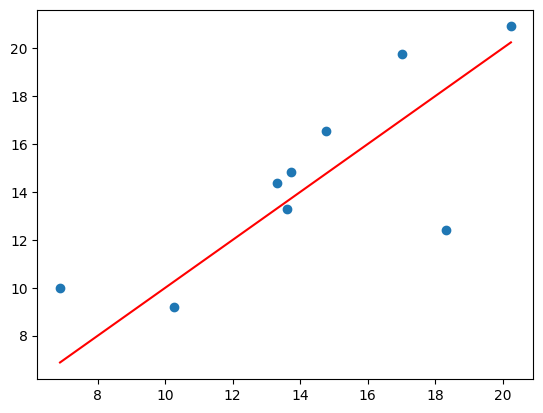

In [24]:
predictions = final_model.predict(X_test).reshape(-1, 1)
predictions = y_scaler.inverse_transform(predictions)
y_true = y_scaler.inverse_transform(y_test)

# Plot predictions vs actual
plt.scatter(y_true, predictions)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.show()

In [19]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate, plot_contour
plot_optimization_history(study)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 997, 998, 999],
              'y': [4.114075197717555, 4.033659545068803, 4.2690127675963145, ...,
                    2.2316150507367434, 2.070931631154107, 1.6721623076739425]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 997, 998, 999],
              'y': [4.114075197717555, 4.033659545068803, 4.033659545068803, ...,
                    1.4871418058944526, 1.4871418058944526, 1.4871418058944526]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})